# Running SCORE on a Single Image

## Import Libraries

In [29]:
%matplotlib inline
import sys
import pickle

# Define paths and directories
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)

# Load libraries
from score import score
import numpy as np
import matplotlib.pyplot as plt
import PIL
from cv2 import resize, INTER_AREA

# Define functions
def decimate_im(input_im, decim_f):
    """Decimate image.
    Decimated by a factor of decim_f.
    Based on the PIL library using the default interpolator.
    Default: PIL.Image.BICUBIC.
    """
    pil_im = PIL.Image.fromarray(input_im)
    (width, height) = (pil_im.width // decim_f, pil_im.height // decim_f)
    im_resized = pil_im.resize((width, height))
    return np.array(im_resized)
def downsample_im(input_im, output_dim):
    """Downsample image.
    Based on opencv function resize.
    [doc](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#void%20resize(InputArray%20src,%20OutputArray%20dst,%20Size%20dsize,%20double%20fx,%20double%20fy,%20int%20interpolation))
    The input image is downsampled to the dimensions specified in `output_dim`.
    The downsampling method is based on the `INTER_AREA` method.
    See [tensorflow_doc](https://www.tensorflow.org/api_docs/cc/class/tensorflow/ops/resize-area)
    Each output pixel is computed by first transforming the pixel's footprint
    into the input tensor and then averaging the pixels that intersect the
    footprint. An input pixel's contribution to the average is weighted by the
    fraction of its area that intersects the footprint.
    This is the same as OpenCV's INTER_AREA.
    An explanation of the INTER_AREA method can be found in the next
    [link](https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3).
    This version should be consistent with the tensorflow one.
    Parameters
    ----------
    input_im: np.ndarray (dim_x, dim_y)
        input image
    output_dim: int
        Contains the dimension of the square output image.
    """
    return resize(input_im, (output_dim, output_dim), interpolation=INTER_AREA)

## Load Data

In [30]:
f = open(data_path+"cfht_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

In [31]:
for key in batch:
    print(key, batch[key].shape)
    
n_batch = batch['psf_hst'].shape[0]
# generate the psfs in the spatial domain
shape = batch['inputs'].shape[-1]
psf_hst = zoom(np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0])),0.5)
psf_partial = np.array([c/h for c,h in zip(batch['psf_cfht'],batch['psf_hst'])])
psf_tile_cfht = np.array([downsample_im(np.fft.ifftshift(np.fft.irfft2(p)),shape) for p in psf_partial])
psf_tile_cfht = np.array([p/p.sum() for p in psf_tile_cfht])
# make psf tiles
psf_tile_hst = np.repeat(psf_hst[np.newaxis, :, :], n_batch, axis=0)

flux_radius (3072,)
inputs (3072, 64, 64)
mag_auto (3072,)
ps_cfht (3072, 64, 33)
ps_hst (3072, 64, 33)
psf_cfht (3072, 128, 65)
psf_hst (3072, 128, 65)
targets (3072, 64, 64)
attributes (3072, 2)
inputs_noiseless (3072, 64, 64, 1)
inputs_cfht (3072, 128, 128)
inputs_tikho (3072, 64, 64)
windows (3072, 64, 64)
windows_flag (3072,)
targets_mom (2, 3072)
target_ell (2, 3072)


In [32]:
gals_obs = batch['inputs'][batch['windows_flag']][:2]
# psfs = np.array([np.fft.ifftshift(np.fft.irfft2(p, s=[64,64])) for p in batch['psf_cfht'][batch['windows_flag']][:2]])
psfs = psf_tile_cfht[batch['windows_flag']][:2]
# psf_hst = np.fft.ifftshift(np.fft.irfft2(batch['psf_hst'][0], s=[64,64]))

## Initialize SCORE

In [33]:
#initiate instances of score
#set the value of gamma
g1 = score(gamma=1,rip=False, verbose=False)

## Run SCORE

In [34]:
#loop
sol_g1 = []

for obs, psf in zip(gals_obs,psfs):
    #deconvolve
    g1.deconvolve(obs=obs,psf=psf)
    sol_g1 += [g1.solution]

In [35]:
g1.k, g1.n_itr

(4, 150)

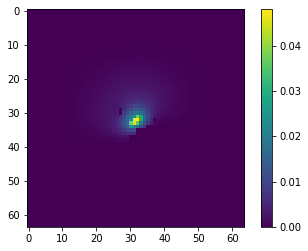

In [36]:
plt.imshow(sol_g1[0]);plt.colorbar()

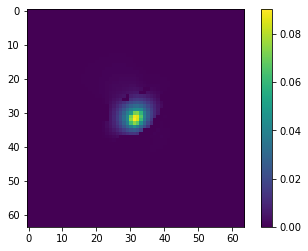

In [37]:
plt.imshow(sol_g1[1]);plt.colorbar()

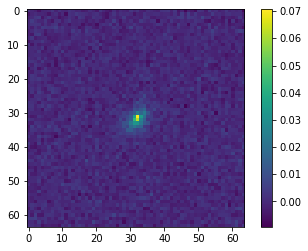

In [38]:
plt.imshow(batch['targets'][batch['windows_flag']][0]);plt.colorbar()

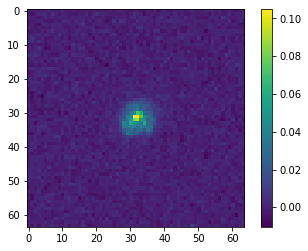

In [39]:
plt.imshow(batch['targets'][batch['windows_flag']][1]);plt.colorbar()

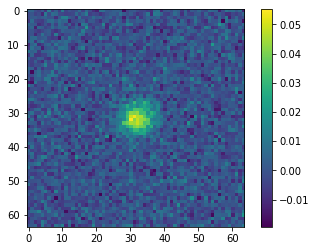

In [40]:
from scipy.signal import convolve
plt.imshow(batch['inputs'][batch['windows_flag']][1]);plt.colorbar()